In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_parquet('/kaggle/input/ariel-data-challenge-2025/train/1010375142/AIRS-CH0_signal_0.parquet')
print(df.head()) 

   column_0  column_1  column_2  column_3  column_4  column_5  column_6  \
0       436       430       435       434       441       436       417   
1       442       430       435       428       440       427       431   
2       440       436       438       431       432       436       439   
3       433       443       443       441       438       428       436   
4       430       442       434       439       448       429       424   

   column_7  column_8  column_9  ...  column_11382  column_11383  \
0       438       444       441  ...           445           434   
1       445       446       434  ...           440           435   
2       430       426       436  ...           443           435   
3       426       435       437  ...           454           439   
4       438       434       448  ...           430           435   

   column_11384  column_11385  column_11386  column_11387  column_11388  \
0           443           432           430           445        

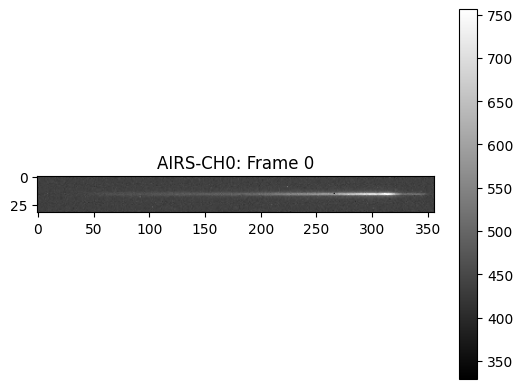

In [4]:
image = df.iloc[0].values.reshape(32, -1)
plt.imshow(image, cmap='gray')
plt.title('AIRS-CH0: Frame 0')
plt.colorbar()
plt.show()

In [5]:
axis = pd.read_parquet('/kaggle/input/ariel-data-challenge-2025/axis_info.parquet')
axis.head()

,AIRS-CH0-axis0-h,AIRS-CH0-axis2-um,AIRS-CH0-integration_time,FGS1-axis0-h
0,0.000028,4.078463,0.1,0.000028
1,0.000056,4.074023,4.5,0.000056
2,0.001361,4.069568,0.1,0.000139
3,0.001389,4.065100,4.5,0.000167
4,0.002694,4.060618,0.1,0.000250


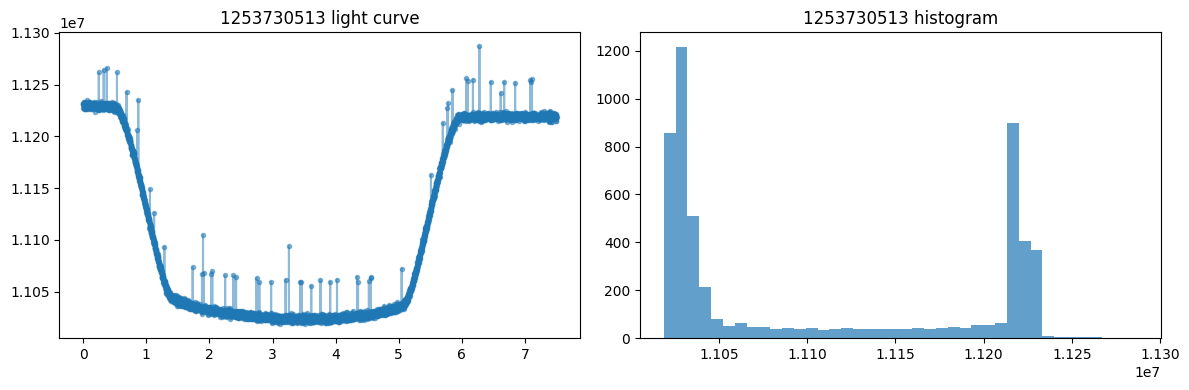

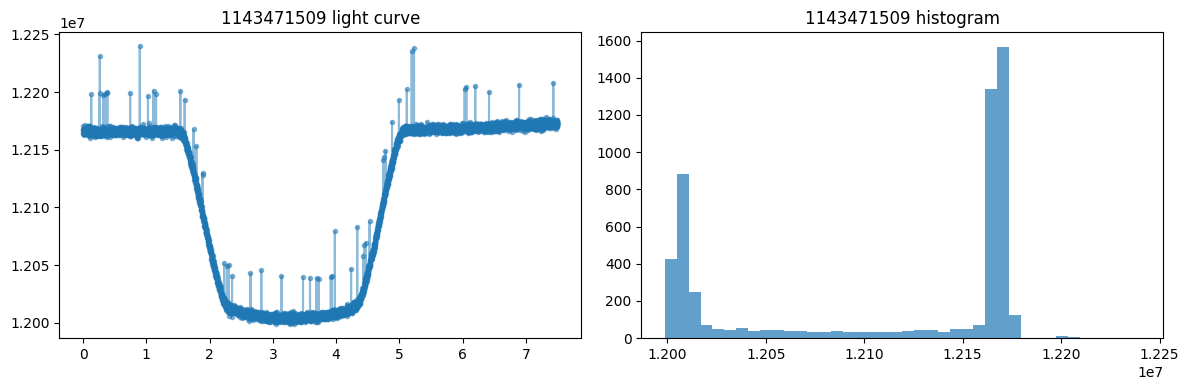

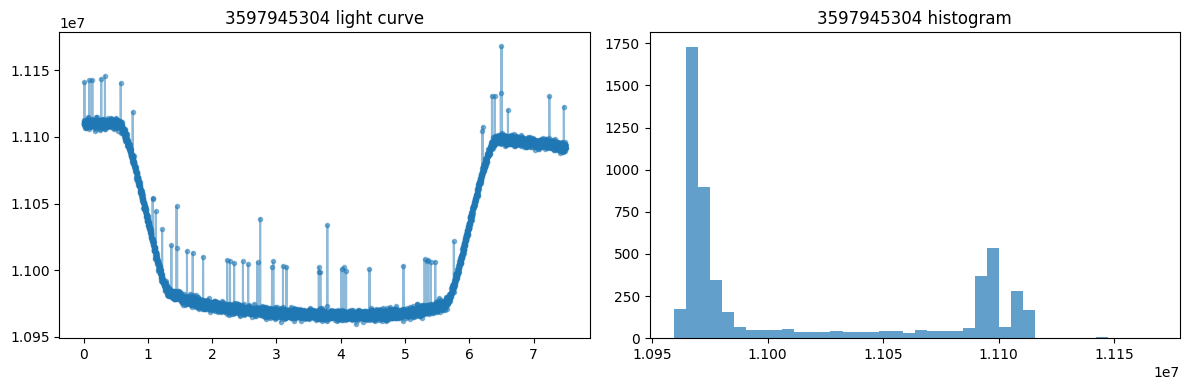

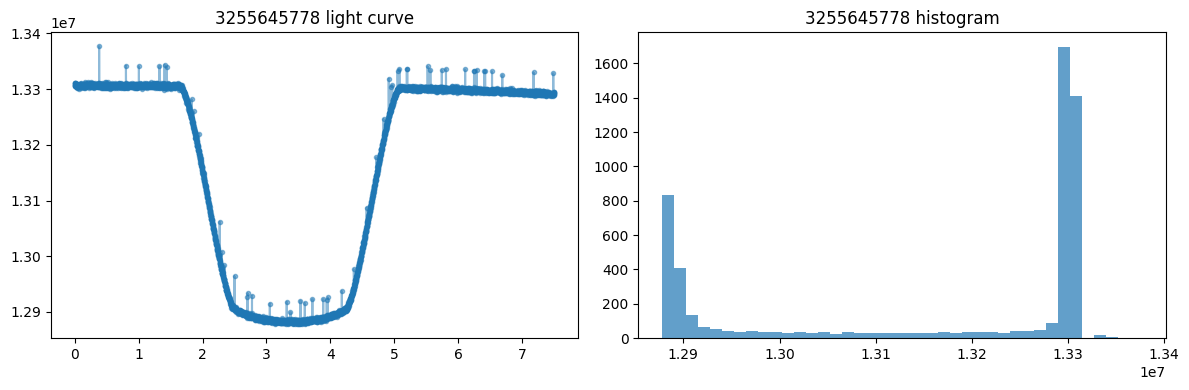

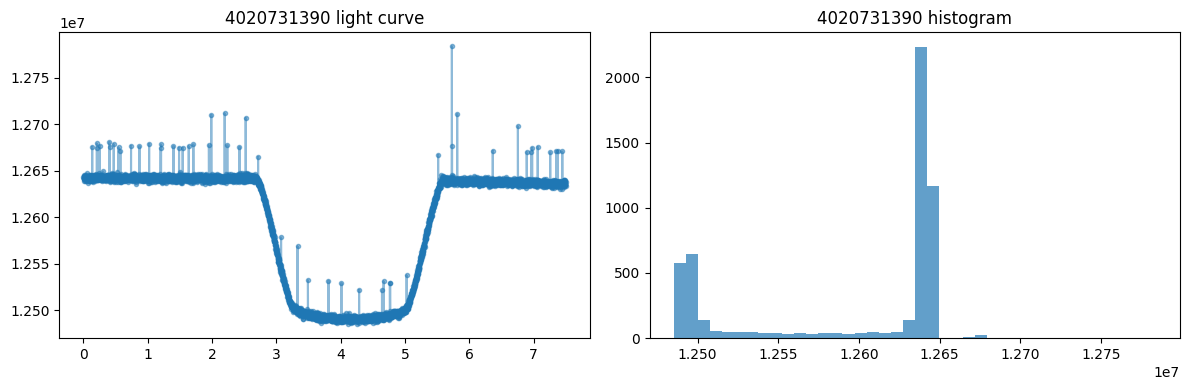

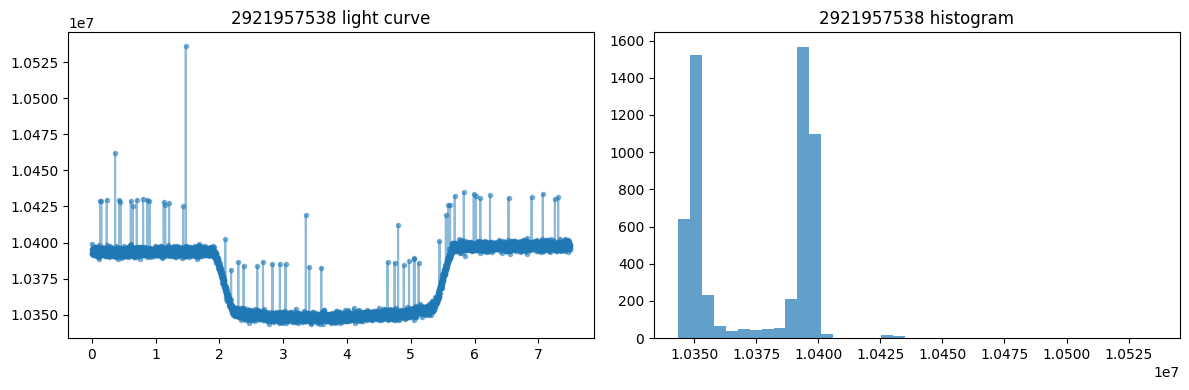

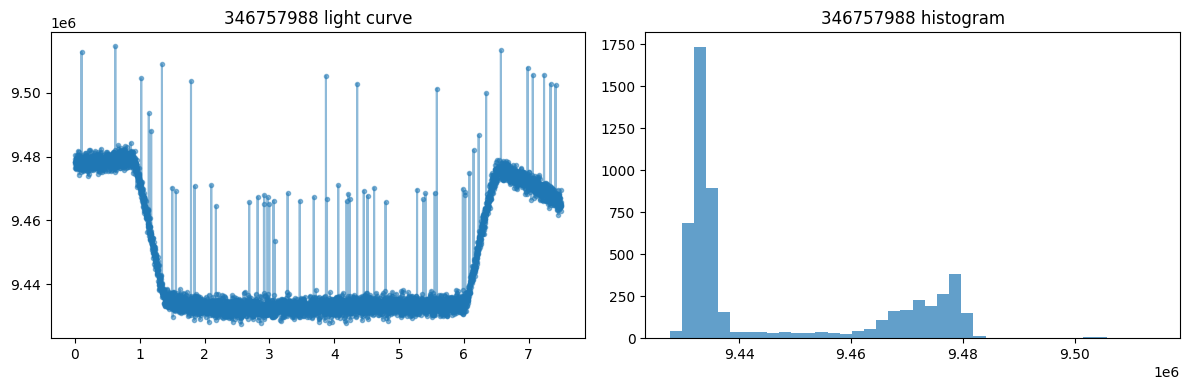

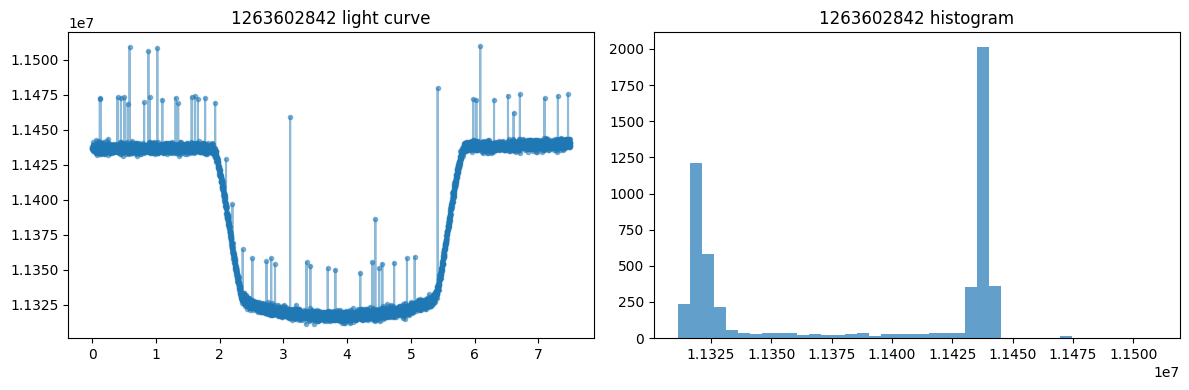

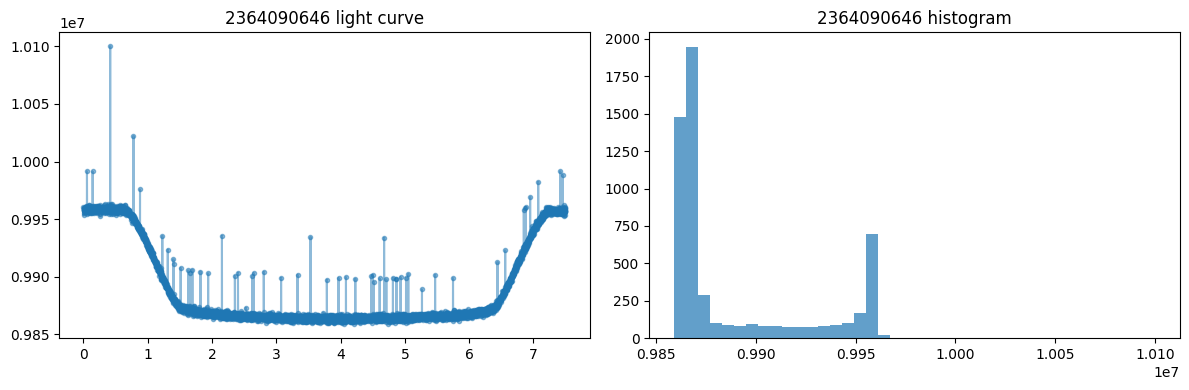

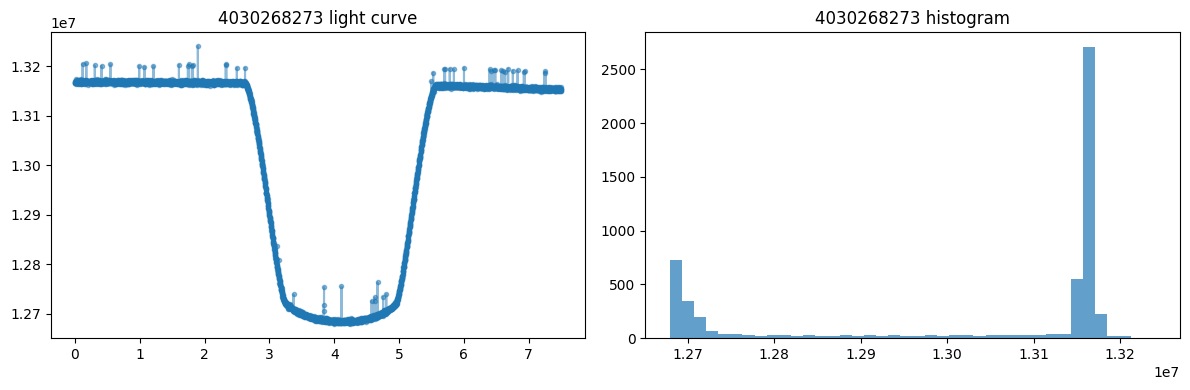

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np

paths = glob.glob('/kaggle/input/ariel-data-challenge-2025/train/*/AIRS-CH0_signal_0.parquet')

for path in paths[:10]:
    pid = path.split('/')[-2]
    df = pd.read_parquet(path)
    axis = pd.read_parquet('/kaggle/input/ariel-data-challenge-2025/axis_info.parquet')
    time = axis['AIRS-CH0-axis0-h'][:df.shape[0]]

    bright = df.sum(axis=1)

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(time[bright>7e6], bright[bright>7e6], marker='.', alpha=0.5)
    plt.title(f'{pid} light curve')

    plt.subplot(1,2,2)
    plt.hist(bright[bright>7e6], bins=40, alpha=0.7)
    plt.title(f'{pid} histogram')

    plt.tight_layout()
    plt.show()

# Dip cleaning and calibration
Ideas taken from GordonYip's "Calibrating and Binning Ariel Data" notebook: https://www.kaggle.com/code/gordonyip/calibrating-and-binning-ariel-data

In [6]:
from astropy.stats import sigma_clip
from sklearn.cluster import KMeans

def calibrate_airs_ch0(signal_path, calibration_path, adc_info={'gain': .4369, 'offset': -1000}, sigma=5, bin_size=1):
    signal = pd.read_parquet(signal_path).values.astype(np.float64)
    if adc_info is not None:
        gain, offset = adc_info['gain'], adc_info['offset']
        signal = signal / gain + offset
        
    dark = pd.read_parquet(os.path.join(calibration_path, 'dark.parquet')).values
    dead = pd.read_parquet(os.path.join(calibration_path, 'dead.parquet')).values
    flat = pd.read_parquet(os.path.join(calibration_path, 'flat.parquet')).values
    
    rows, cols = 32, 356
    signal_3d = signal.reshape(signal.shape[0], rows, cols)
    dark_3d = dark.reshape(rows, cols)
    dead_3d = dead.reshape(rows, cols)
    flat_3d = flat.reshape(rows, cols)
    hot_mask = sigma_clip(dark_3d, sigma=sigma, maxiters=5).mask
    signal_3d = np.ma.masked_array(signal_3d, mask=np.tile(dead_3d | hot_mask, (signal.shape[0], 1, 1)))
    if signal_3d.shape[0] % 2 != 0:
        signal_3d = signal_3d[:-1, :, :]
    cds_signal = signal_3d[1::2, :, :] - signal_3d[::2, :, :]

    cds_calibrated = cds_signal / np.where(flat_3d < 0.1, 1.0, flat_3d)[None, :, :]
    
    if bin_size > 1:
        n_frames_b, _, _ = cds_calibrated.shape
        n_bins = n_frames_b // bin_size
        if n_bins == 0:
            final_signal = cds_calibrated.mean(axis=0, keepdims=True)
        else:
            signal_to_bin = cds_calibrated[:n_bins * bin_size]
            final_signal = signal_to_bin.reshape(n_bins, bin_size, rows, cols).mean(axis=1)
    else:
        final_signal = cds_calibrated
        
    return final_signal, signal.shape[0]

In [7]:
import os

def detrend_light_curve(time, bright):
    def polyfit_bright(bright, sigma=2, deg=1):
        kmeans = KMeans(n_clusters=2, n_init='auto', random_state=42)
        labels = kmeans.fit_predict(bright.reshape(-1, 1))
        mask = (labels != np.argmin(kmeans.cluster_centers_))
        mask[mask] *= ~sigma_clip(bright[mask], sigma=sigma).mask
        
        trend_coeffs = np.polyfit(time[mask], bright[mask], deg=deg)
        normalized = bright / np.poly1d(trend_coeffs)(time)
        return normalized, mask
        
    normalized, _ = polyfit_bright(bright, 2, 1)
    normalized, _ = polyfit_bright(normalized, 2, 2)
    normalized, mask = polyfit_bright(normalized, 1.75, 2)

    return normalized, mask

def analyze_light_curves(root_path, max_planets=10, bin_size=10):
    planet_ids = os.listdir(root_path)[:max_planets]
    axis_info = pd.read_parquet('/kaggle/input/ariel-data-challenge-2025/axis_info.parquet')

    for pid in planet_ids:
        print(f"--- Processing Planet ID: {pid} ---")
        try:
            signal_path = os.path.join(root_path, pid, 'AIRS-CH0_signal_0.parquet')
            calibration_path = os.path.join(root_path, pid, 'AIRS-CH0_calibration_0')

            if not os.path.exists(signal_path) or not os.path.exists(calibration_path):
                print(f"Skipping {pid}: files not found.")
                continue

            processed_signal, original_frames = calibrate_airs_ch0(
                signal_path, calibration_path, bin_size=bin_size
            )

            bright = processed_signal.sum(axis=(1, 2))

            time_raw = axis_info['AIRS-CH0-axis0-h'][:original_frames].values
            if len(time_raw) % 2 != 0:
                time_raw = time_raw[:-1]
            time_cds = (time_raw[1::2] + time_raw[::2]) / 2

            if bin_size > 1 and len(bright) > 0:
                time_binned = time_cds[:len(bright) * bin_size].reshape(-1, bin_size).mean(axis=1)
            else:
                time_binned = time_cds[:len(bright)]

            if len(bright) < 10:
                print("Not enough data to analyze. Skipping.")
                continue

            normalized_bright, plateau_mask = detrend_light_curve(time_binned, bright)
            
            plt.figure(figsize=(12, 4))

            plt.subplot(1, 2, 1)
            plt.plot(time_binned, normalized_bright, marker='.', linestyle='-', alpha=0.8, markersize=4)
            plt.title(f'{pid} Normalized Light Curve')
            plt.xlabel(f'Time (hours, {bin_size}-frame bins)')
            plt.ylabel('Normalized Brightness')
            plt.grid(True, alpha=0.4)
            plt.ylim(np.min(normalized_bright) - 0.005, 1.01)

            plt.subplot(1, 2, 2)
            plt.hist(normalized_bright, bins=30, alpha=0.8, range=(np.min(normalized_bright), 1.01))
            plt.title(f'{pid} Normalized Distribution')
            plt.xlabel('Normalized Brightness')
            plt.grid(True, alpha=0.4)

            plt.tight_layout()
            plt.show()

            print(f"\n--- PLANET {pid} DETRENDED STATS ---")
            print(f"Transit depth: ~{(1 - np.min(normalized_bright)) * 100:.3f}%")
            if np.any(plateau_mask):
                print(f"Noise level (std of plateau): {np.std(normalized_bright[plateau_mask]):.4f}")

        except Exception as e:
            print(f"!!! ERROR processing {pid}: {e} !!!")
            continue

--- Processing Planet ID: 1253730513 ---


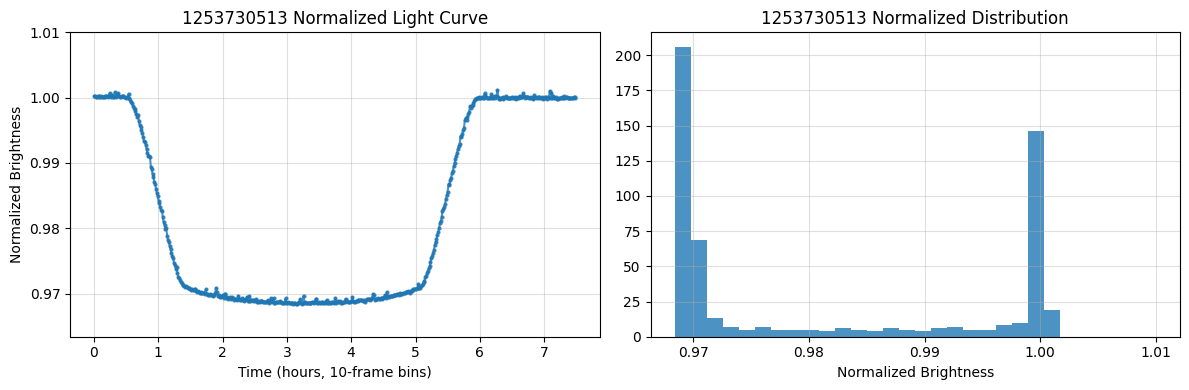


--- PLANET 1253730513 DETRENDED STATS ---
Transit depth: ~3.161%
Noise level (std of plateau): 0.0001
--- Processing Planet ID: 1143471509 ---


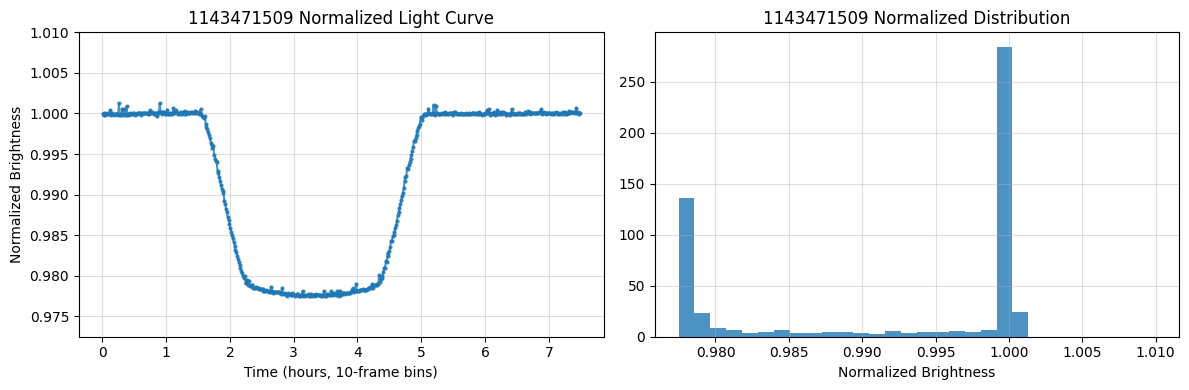


--- PLANET 1143471509 DETRENDED STATS ---
Transit depth: ~2.252%
Noise level (std of plateau): 0.0001
--- Processing Planet ID: 3597945304 ---


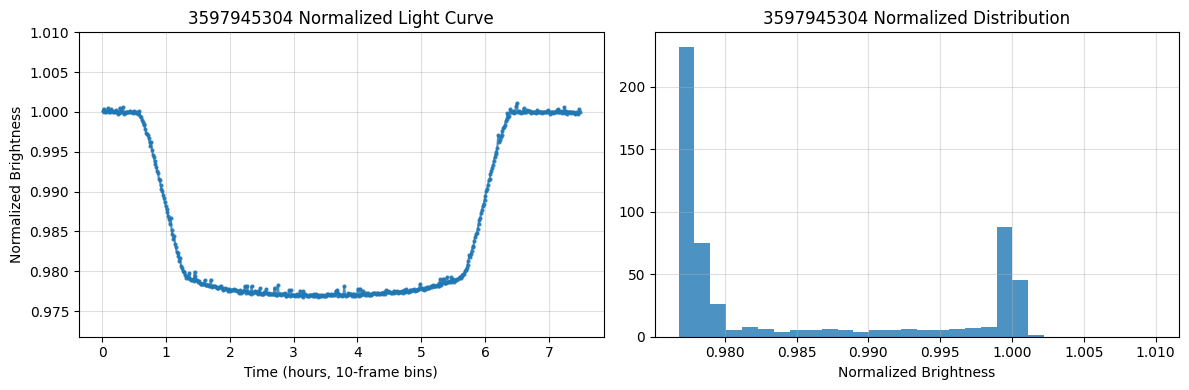


--- PLANET 3597945304 DETRENDED STATS ---
Transit depth: ~2.322%
Noise level (std of plateau): 0.0001
--- Processing Planet ID: 3255645778 ---


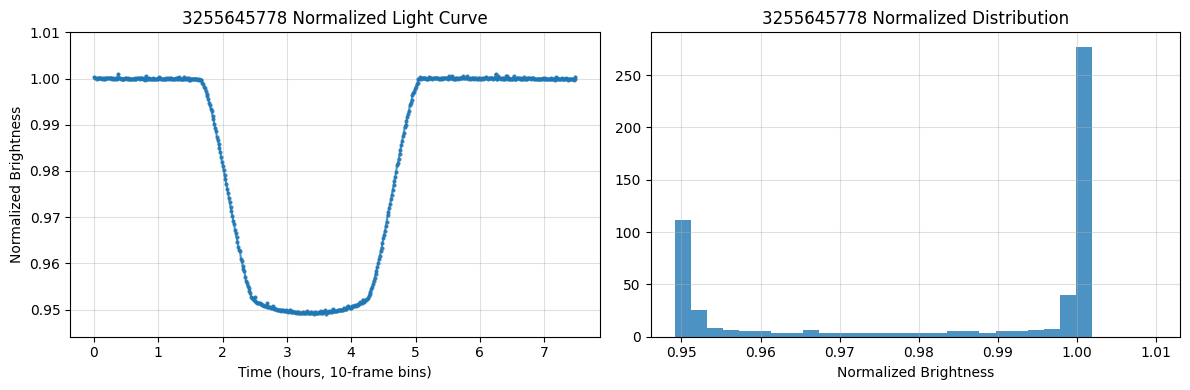


--- PLANET 3255645778 DETRENDED STATS ---
Transit depth: ~5.086%
Noise level (std of plateau): 0.0001
--- Processing Planet ID: 4020731390 ---


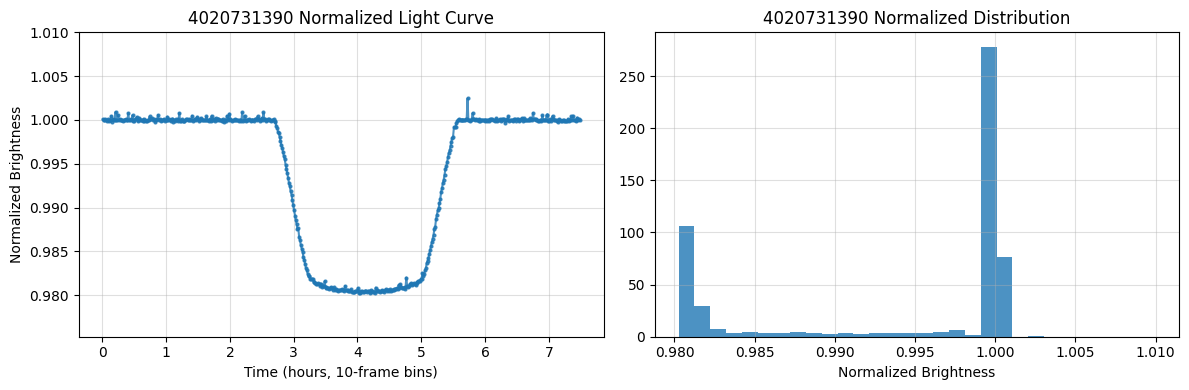


--- PLANET 4020731390 DETRENDED STATS ---
Transit depth: ~1.975%
Noise level (std of plateau): 0.0001
--- Processing Planet ID: 2921957538 ---


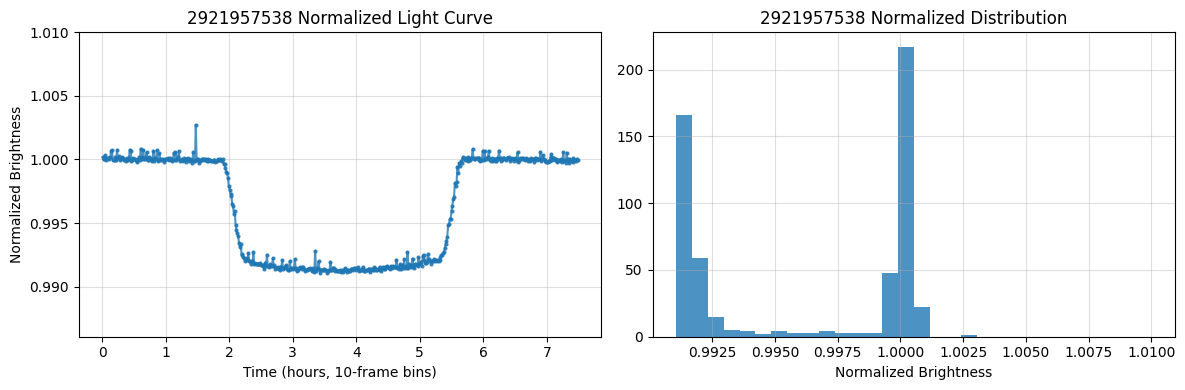


--- PLANET 2921957538 DETRENDED STATS ---
Transit depth: ~0.894%
Noise level (std of plateau): 0.0001
--- Processing Planet ID: 346757988 ---


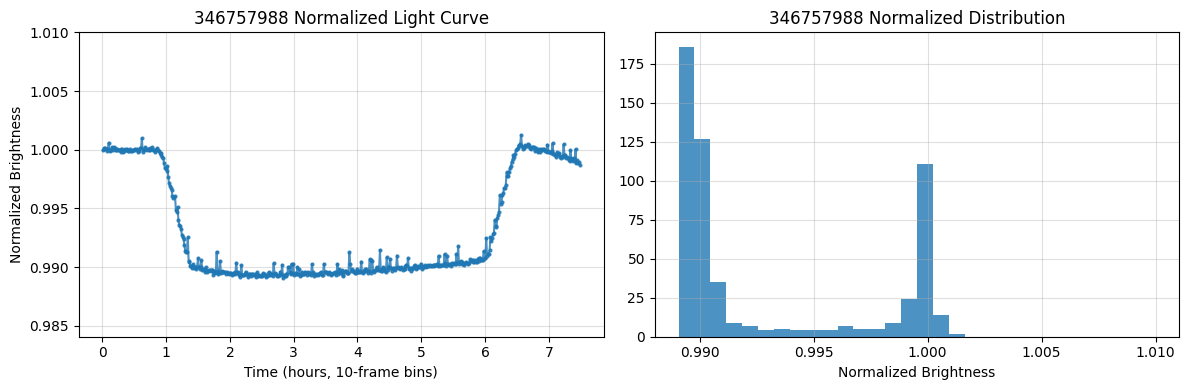


--- PLANET 346757988 DETRENDED STATS ---
Transit depth: ~1.093%
Noise level (std of plateau): 0.0001
--- Processing Planet ID: 1263602842 ---


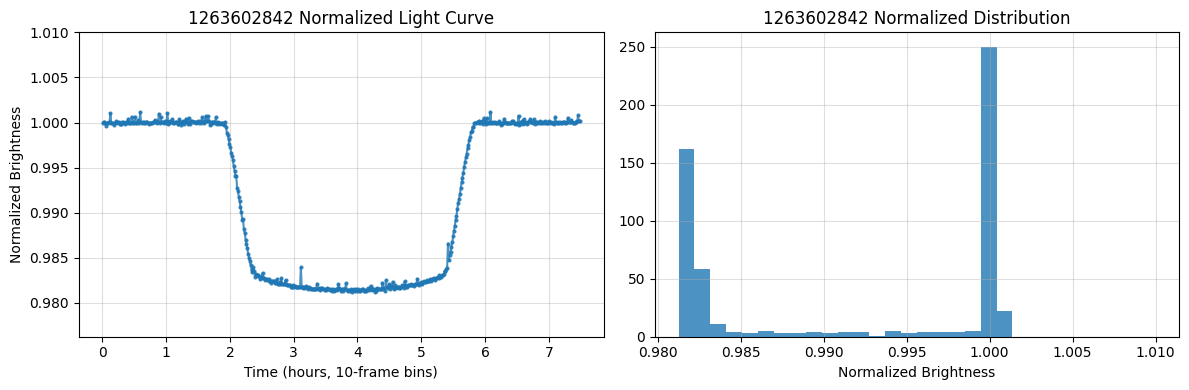


--- PLANET 1263602842 DETRENDED STATS ---
Transit depth: ~1.874%
Noise level (std of plateau): 0.0001
--- Processing Planet ID: 2364090646 ---


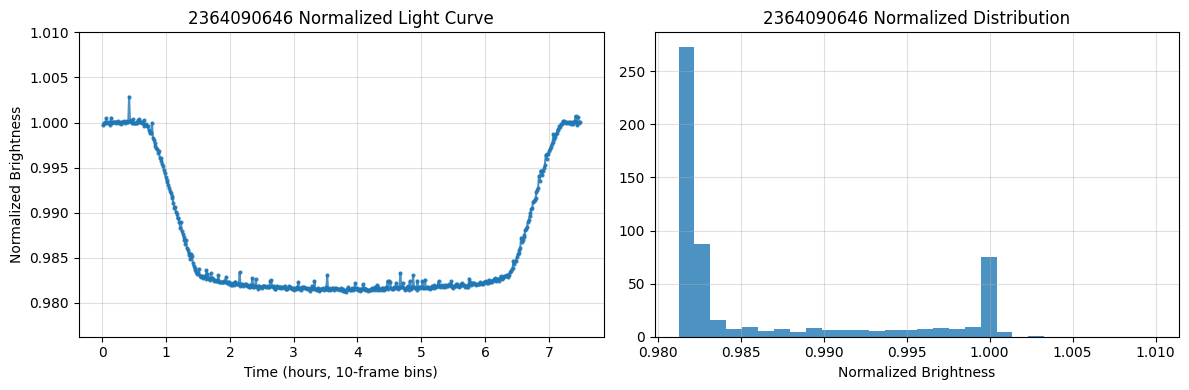


--- PLANET 2364090646 DETRENDED STATS ---
Transit depth: ~1.874%
Noise level (std of plateau): 0.0001
--- Processing Planet ID: 4030268273 ---


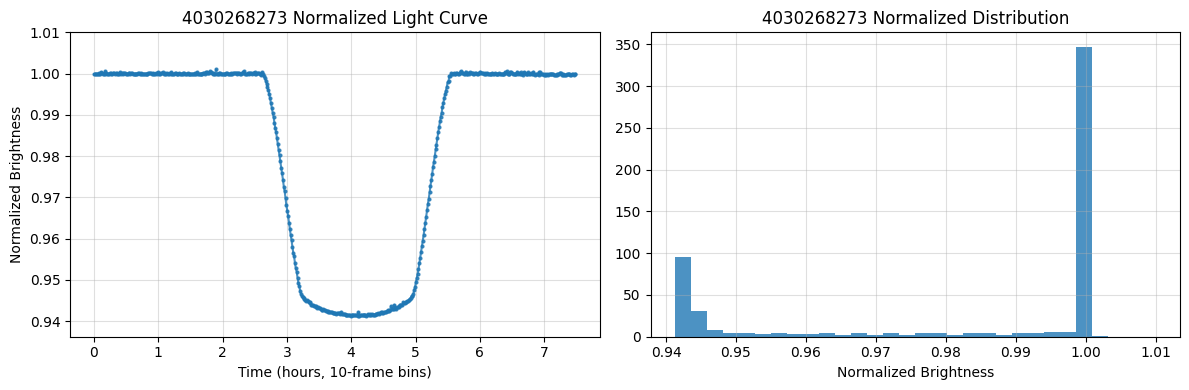


--- PLANET 4030268273 DETRENDED STATS ---
Transit depth: ~5.876%
Noise level (std of plateau): 0.0001


In [8]:
root = '/kaggle/input/ariel-data-challenge-2025/train/'
analyze_light_curves(root, 10)

# Spectrum

In [9]:
def detrend_light_curve(time, bright):
    if len(np.where(~np.isnan(bright))[0]) < 2: return bright, np.zeros_like(bright, dtype=bool)
    
    mask = ~sigma_clip(bright, sigma=2).mask
    if not np.any(mask): mask = np.ones_like(bright, dtype=bool)
    coeffs = np.polyfit(time[mask], bright[mask], deg=1)
    normalized_bright = bright / np.poly1d(coeffs)(time)
    
    mask = ~sigma_clip(normalized_bright, sigma=2).mask
    if not np.any(mask): mask = np.ones_like(bright, dtype=bool)
    coeffs = np.polyfit(time[mask], bright[mask], deg=2)
    normalized_bright = bright / np.poly1d(coeffs)(time)

    mask = ~sigma_clip(normalized_bright, sigma=1.75).mask
    if not np.any(mask): mask = np.ones_like(bright, dtype=bool)
    coeffs = np.polyfit(time[mask], bright[mask], deg=2)
    normalized_bright = bright / np.poly1d(coeffs)(time)
    
    return normalized_bright, mask

def build_spectrum(root_path, max_planets=1):
    target_wls = pd.read_csv('/kaggle/input/ariel-data-challenge-2025/wavelengths.csv').values.flatten()
    axis_info = pd.read_parquet('/kaggle/input/ariel-data-challenge-2025/axis_info.parquet')
    detector_wls = axis_info['AIRS-CH0-axis2-um'].values[:356]

    bin_edges = (target_wls[:-1] + target_wls[1:]) / 2.0
    bin_indices = np.digitize(detector_wls, bin_edges)

    planet_ids = os.listdir(root_path)[:max_planets]
    for pid in planet_ids:
        print(f"--- Building Spectrum for Planet ID: {pid} ---")
        try:
            signal_path = os.path.join(root_path, pid, 'AIRS-CH0_signal_0.parquet')
            calibration_path = os.path.join(root_path, pid, 'AIRS-CH0_calibration_0')
            
            calibrated_signal, original_frames = calibrate_airs_ch0(signal_path, calibration_path)
            
            time_raw = axis_info['AIRS-CH0-axis0-h'][:original_frames].values
            if len(time_raw) % 2 != 0:
                time_raw = time_raw[:-1]
            time_cds = (time_raw[1::2] + time_raw[::2]) / 2

            spectrum_depths = []
            spectrum_errors = []
            
            for i in range(len(target_wls)):
                cols_for_this_bin = np.where(bin_indices == i)[0]
                
                if len(cols_for_this_bin) == 0:
                    spectrum_depths.append(np.nan)
                    spectrum_errors.append(np.nan)
                    continue

                binned_lc_3d = calibrated_signal[:, :, cols_for_this_bin]
                bright = binned_lc_3d.sum(axis=(1, 2))
            
                normalized_bright, plateau_mask = detrend_light_curve(time_cds, bright)
            
                transit_depth = 1.0 - np.min(normalized_bright)
                noise = np.std(normalized_bright[plateau_mask])
                
                spectrum_depths.append(transit_depth)
                spectrum_errors.append(noise)
                
            plt.figure(figsize=(10, 5))
            plt.errorbar(target_wls, np.array(spectrum_depths) * 1e6, yerr=np.array(spectrum_errors) * 1e6, 
                         fmt='o', capsize=3, markersize=4, color='red')
            plt.title(f'Transmission Spectrum for {pid}')
            plt.xlabel('Wavelength (microns)')
            plt.ylabel('Transit Depth (ppm)')
            plt.grid(True, alpha=0.4)
            plt.show()

        except Exception as e:
            print(f"!!! ERROR processing {pid}: {e} !!!")
            continue

--- Building Spectrum for Planet ID: 1253730513 ---


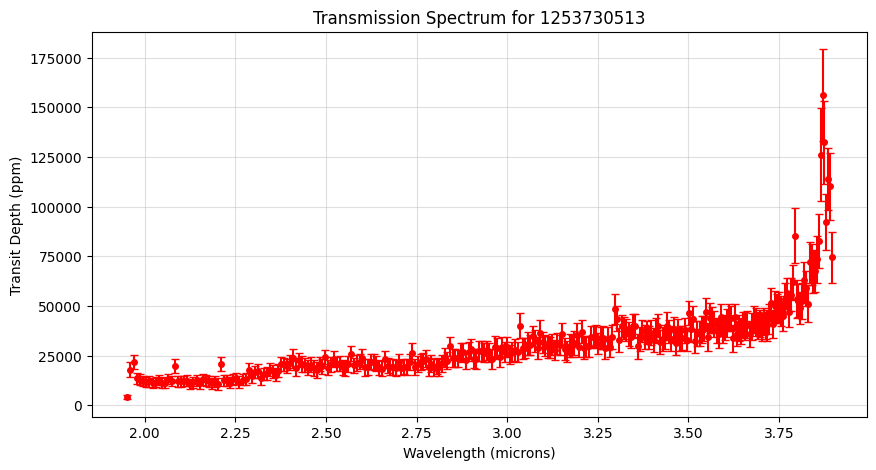

--- Building Spectrum for Planet ID: 1143471509 ---


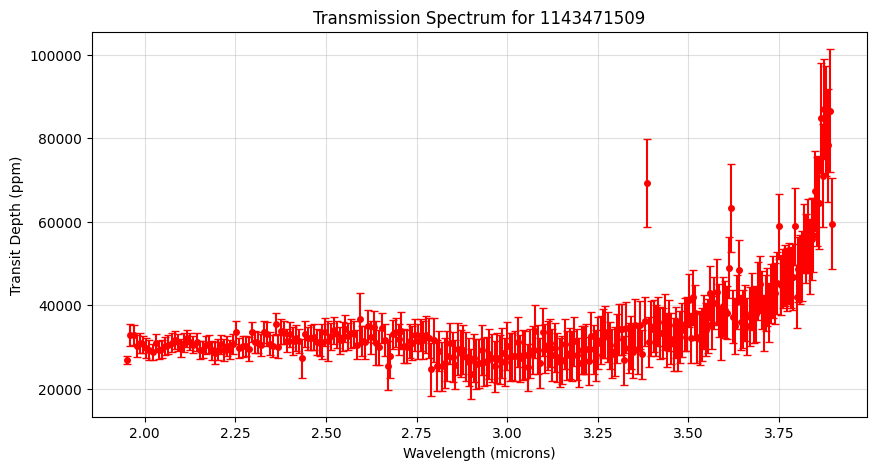

--- Building Spectrum for Planet ID: 3597945304 ---


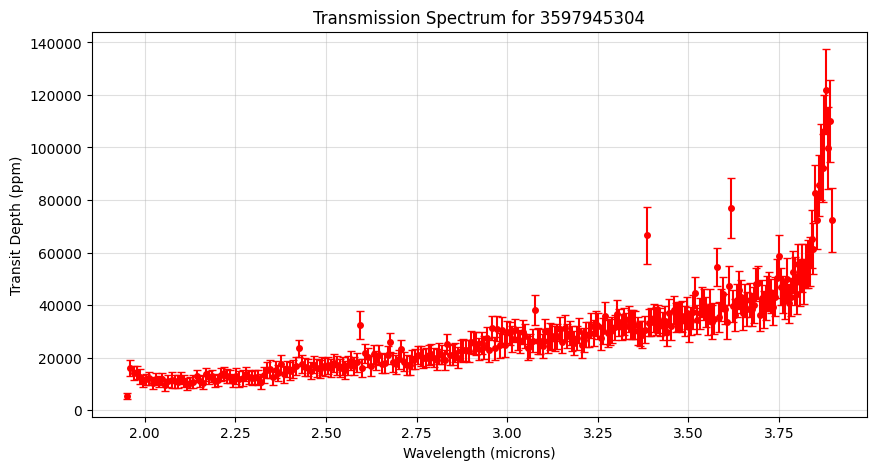

--- Building Spectrum for Planet ID: 3255645778 ---


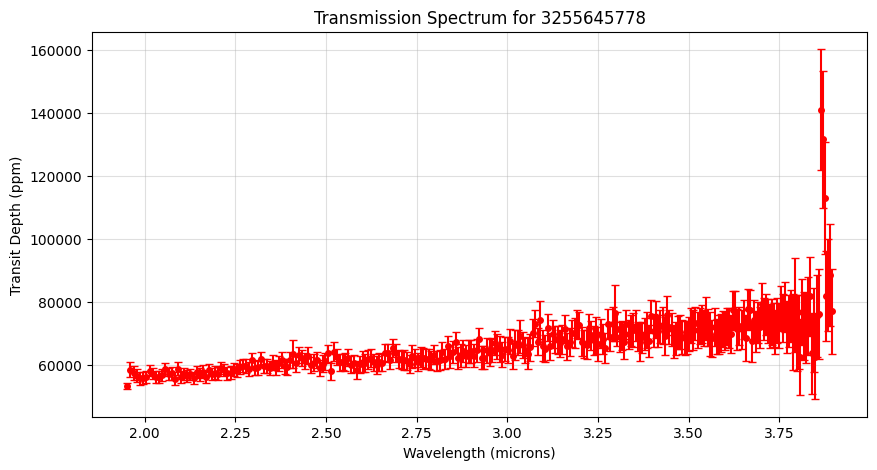

--- Building Spectrum for Planet ID: 4020731390 ---


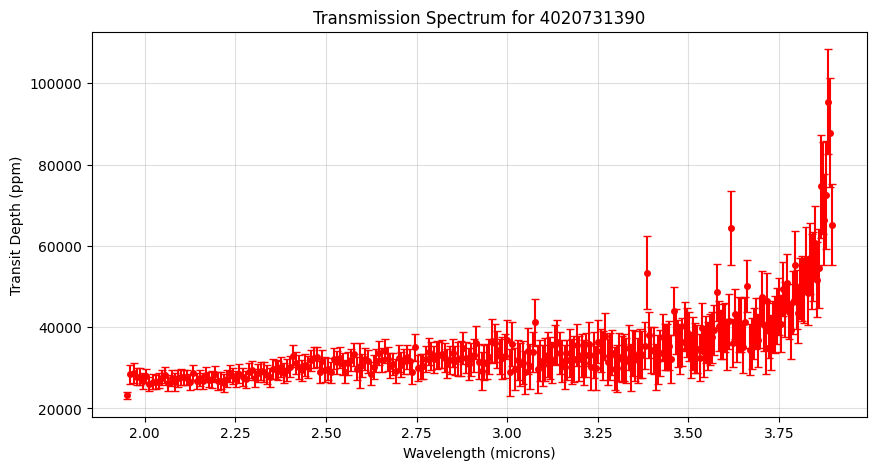

--- Building Spectrum for Planet ID: 2921957538 ---


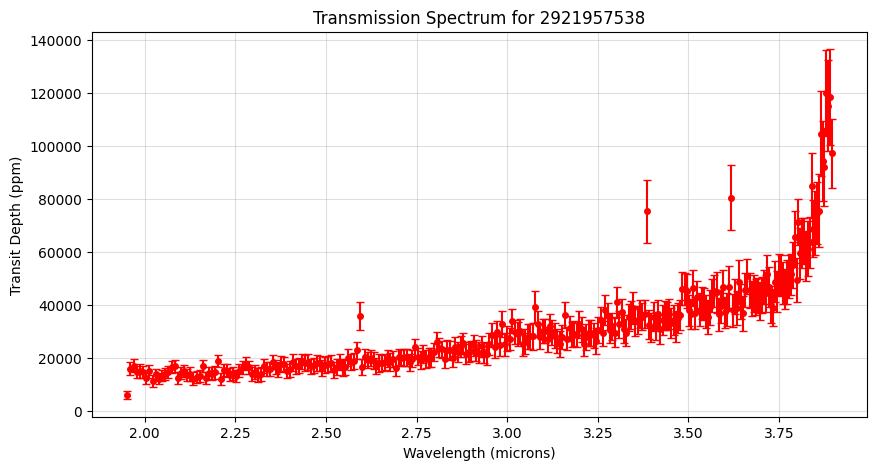

--- Building Spectrum for Planet ID: 346757988 ---


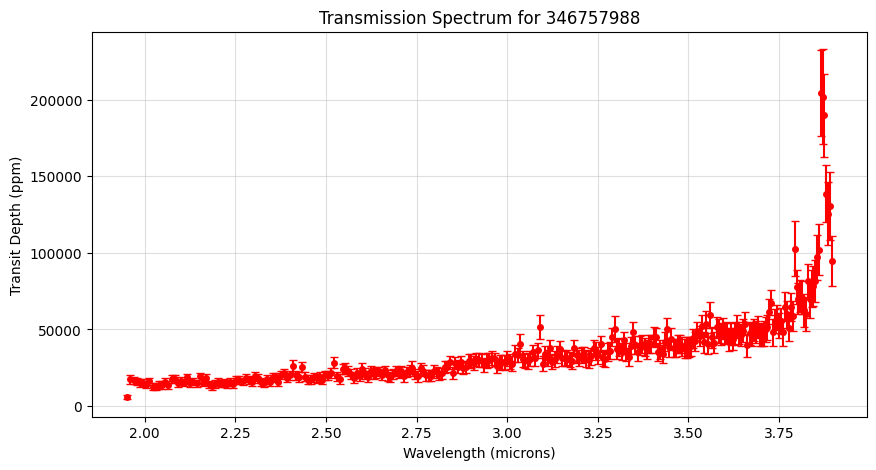

--- Building Spectrum for Planet ID: 1263602842 ---


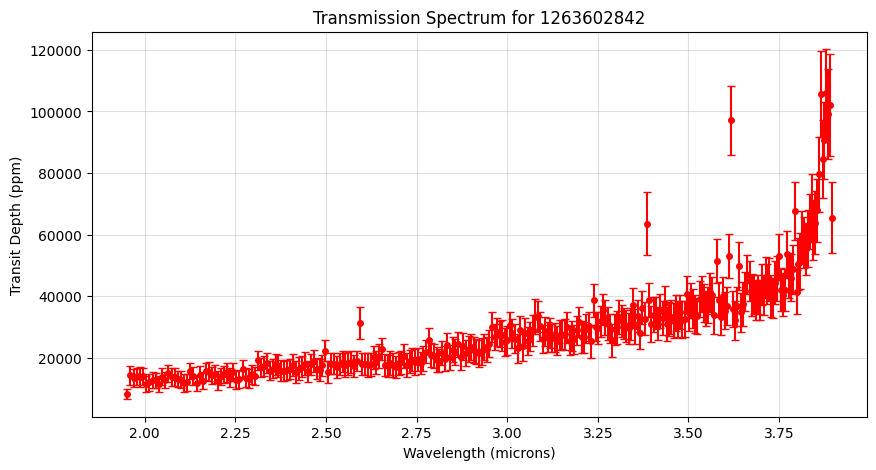

--- Building Spectrum for Planet ID: 2364090646 ---


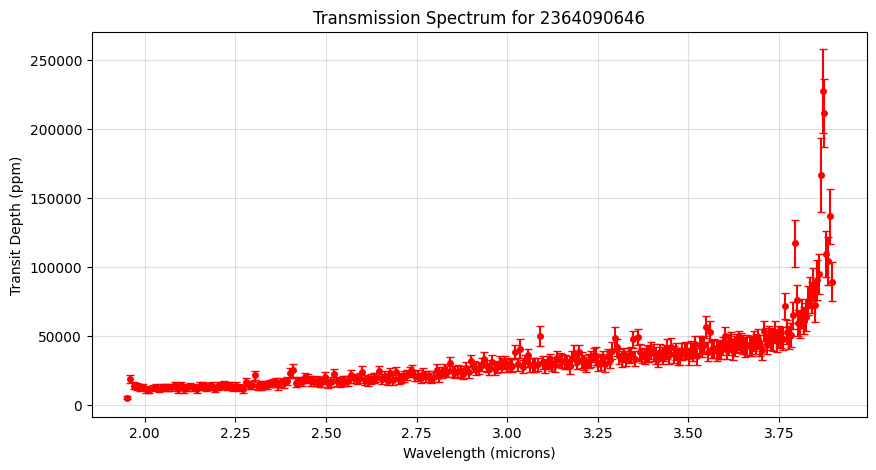

--- Building Spectrum for Planet ID: 4030268273 ---


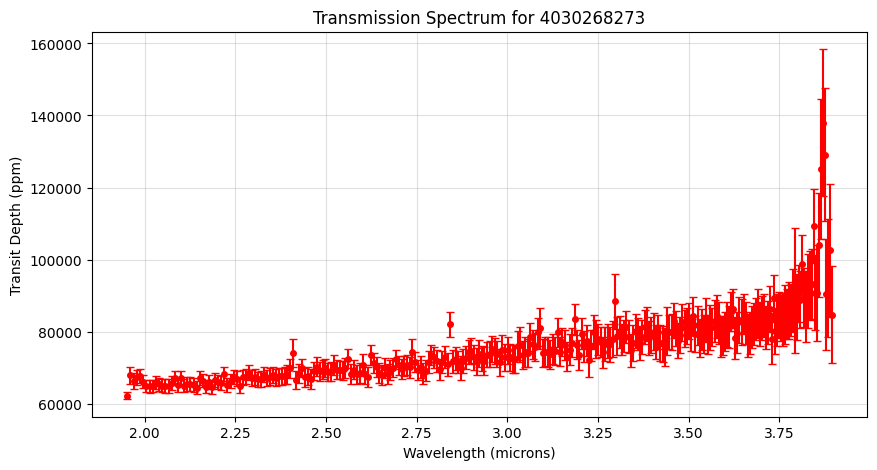

In [10]:
root = '/kaggle/input/ariel-data-challenge-2025/train/'
build_spectrum(root, 10)

# Baseline submissions

In [11]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from astropy.stats import sigma_clip

def calc_submission(root_path, list_planets, wavelengths_csv, axis_info_parquet, out_csv):
    target_wls = pd.read_csv(wavelengths_csv).values.flatten()
    axis_info = pd.read_parquet(axis_info_parquet)
    detector_wls = axis_info['AIRS-CH0-axis2-um'].values[:356]
    bin_edges = (target_wls[:-1] + target_wls[1:]) / 2.0
    bin_indices = np.digitize(detector_wls, bin_edges)

    all_results = []
    
    for pid in tqdm(list_planets, desc='Baseline submission progress'):
        try:
            signal_path = os.path.join(root_path, pid, 'AIRS-CH0_signal_0.parquet')
            calibration_path = os.path.join(root_path, pid, 'AIRS-CH0_calibration_0')
            if not os.path.exists(signal_path) or not os.path.exists(calibration_path):
                print(f"--- Skipping {pid}: files not found ---")
                continue

            calibrated_signal, original_frames = calibrate_airs_ch0(signal_path, calibration_path, bin_size=1)

            time_raw = axis_info['AIRS-CH0-axis0-h'][:original_frames].values
            if len(time_raw) % 2 != 0:
                time_raw = time_raw[:-1]
            time_cds = (time_raw[1::2] + time_raw[::2]) / 2

            spectrum_depths = []
            spectrum_errors = []
            for i in range(len(target_wls)):
                cols_for_this_bin = np.where(bin_indices == i)[0]
                if len(cols_for_this_bin) == 0:
                    spectrum_depths.append(np.nan)
                    spectrum_errors.append(np.nan)
                    continue

                binned_lc_3d = calibrated_signal[:, :, cols_for_this_bin]
                bright = binned_lc_3d.sum(axis=(1, 2))
                normalized_bright, plateau_mask = detrend_light_curve(time_cds, bright)
                transit_depth = 1.0 - np.min(normalized_bright)
                noise = np.std(normalized_bright[plateau_mask])
                spectrum_depths.append(transit_depth)
                spectrum_errors.append(noise)

            result_row = [pid] + list(spectrum_depths) + list(spectrum_errors)
            all_results.append(result_row)
        
        except Exception as e:
            print(f"ERROR for {pid}: {e}")
            continue

    wl_cols = [f'wl_{i+1}' for i in range(len(target_wls))]
    sigma_cols = [f'sigma_{i+1}' for i in range(len(target_wls))]
    header = ['planet_id'] + wl_cols + sigma_cols

    submission = pd.DataFrame(all_results, columns=header)
    submission.to_csv(out_csv, index=False)
    print(f"\n--- Baseline submission is ready ---\nFile saved: {out_csv}")

In [12]:
train_path = '/kaggle/input/ariel-data-challenge-2025/train/'
test_path = '/kaggle/input/ariel-data-challenge-2025/test/'
wavelengths_csv = '/kaggle/input/ariel-data-challenge-2025/wavelengths.csv'
axis_info_parquet = '/kaggle/input/ariel-data-challenge-2025/axis_info.parquet'

train_planets = [f for f in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, f))]
test_planets = [f for f in os.listdir(test_path) if os.path.isdir(os.path.join(test_path, f))]

calc_submission(train_path, train_planets, wavelengths_csv, axis_info_parquet, 'baseline_train_submission.csv')
calc_submission(test_path, test_planets, wavelengths_csv, axis_info_parquet, 'baseline_test_submission.csv')

Baseline submission progress: 100%|██████████| 1100/1100 [2:28:54<00:00,  8.12s/it] 



--- Baseline submission is ready ---\File saved: train_spectrum_submission.csv


Baseline submission progress: 100%|██████████| 1/1 [00:08<00:00,  8.66s/it]


--- Baseline submission is ready ---\File saved: test_submission.csv


Submission files were renamed